# チュートリアル: 伝達関数の測定

このチュートリアルでは、`gwexpy` を使用して測定データからシステムの伝達関数（Transfer Function）を推定し、
物理モデルへのフィッティングを行ってパラメータを同定する流れを解説します。

**シナリオ:**
ある機械振動系（または電気回路）に白色雑音を入力し、その応答を測定しました。
この入出力データから、システムの共振周波数 $f_0$ と Q値 $Q$ を求めます。

**ワークフロー:**
1.  **データ生成**: 入力信号（白色雑音）と、それに対するシステムの出力（共振系応答 + 測定ノイズ）をシミュレーションします。
2.  **伝達関数の推定**: 入出力の時系列データから伝達関数とコヒーレンスを計算し、ボード線図（Bode Plot）を描画します。
3.  **モデルフィッティング**: 推定した伝達関数に理論モデル（ローレンツ関数など）を当てはめ、パラメータを推定します。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from gwexpy import TimeSeries
from gwexpy.plot import Plot

## 1. 実験データの生成（シミュレーション）

仮想的な実験を行います。
*   **システム**: 2次共振系（単振動）
    *   共振周波数 $f_0 = 300$ Hz
    *   Q値 $Q = 50$
*   **入力**: 白色雑音（White Noise）
*   **測定**: サンプリング周波数 2048 Hz, 継続時間 60秒

出力信号には、測定に伴うノイズも付加します。


Input data shape: (122880,)
Output data shape: (122880,)


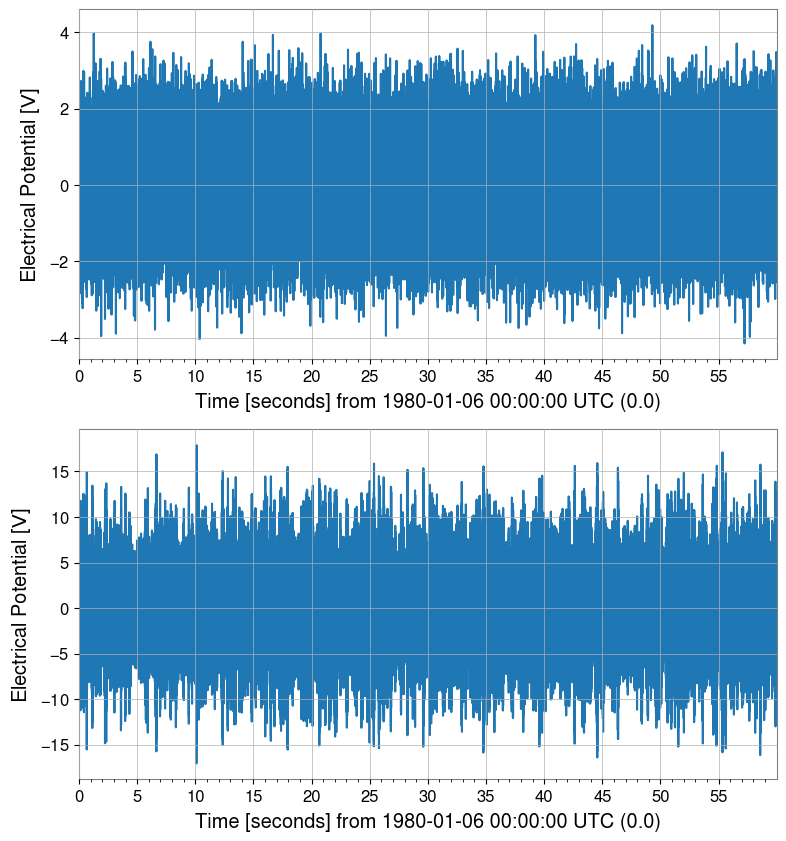

In [2]:
# --- パラメータ設定 ---
fs = 2048.0  # サンプリング周波数 [Hz]
duration = 60.0  # 継続時間 [s]
f0_true = 300.0  # 真の共振周波数 [Hz]
Q_true = 50.0  # 真のQ値

# --- 時間軸と入力信号 ---
t = np.linspace(0, duration, int(duration * fs), endpoint=False)
input_data = np.random.normal(0, 1, size=len(t))  # 白色雑音入力

# --- 物理システムのシミュレーション (scipy.signalを使用) ---
# 伝達関数 H(s) = w0^2 / (s^2 + (w0/Q)s + w0^2)
w0 = 2 * np.pi * f0_true
num = [w0**2]
den = [1, w0 / Q_true, w0**2]
system = signal.TransferFunction(num, den)

# 時間応答の計算 (lsim)
# Time steps for simulation
_, output_clean, _ = signal.lsim(system, U=input_data, T=t)

# --- 測定ノイズの付加 ---
# 出力に少しノイズ（センサーノイズなど）が乗ると仮定
measurement_noise = np.random.normal(0, 0.1, size=len(t))
output_data = output_clean + measurement_noise

# --- gwexpy TimeSeries オブジェクトの作成 ---
ts_input = TimeSeries(input_data, t0=0, sample_rate=fs, name="Input", unit="V")
ts_output = TimeSeries(output_data, t0=0, sample_rate=fs, name="Output", unit="V")

print("Input data shape:", ts_input.shape)
print("Output data shape:", ts_output.shape)
Plot(ts_input, ts_output, separate=True);

## 2. 伝達関数の推定

入出力の時系列データ `ts_input` と `ts_output` から、周波数応答関数（伝達関数）を推定します。
`gwexpy` の `transfer_function` メソッドを使用します。

また、測定の信頼性を確認するために**コヒーレンス（Coherence）**も計算します。
コヒーレンスが 1 に近い周波数帯域は、入出力の関係が線形であり、ノイズの影響が少ないことを示します。


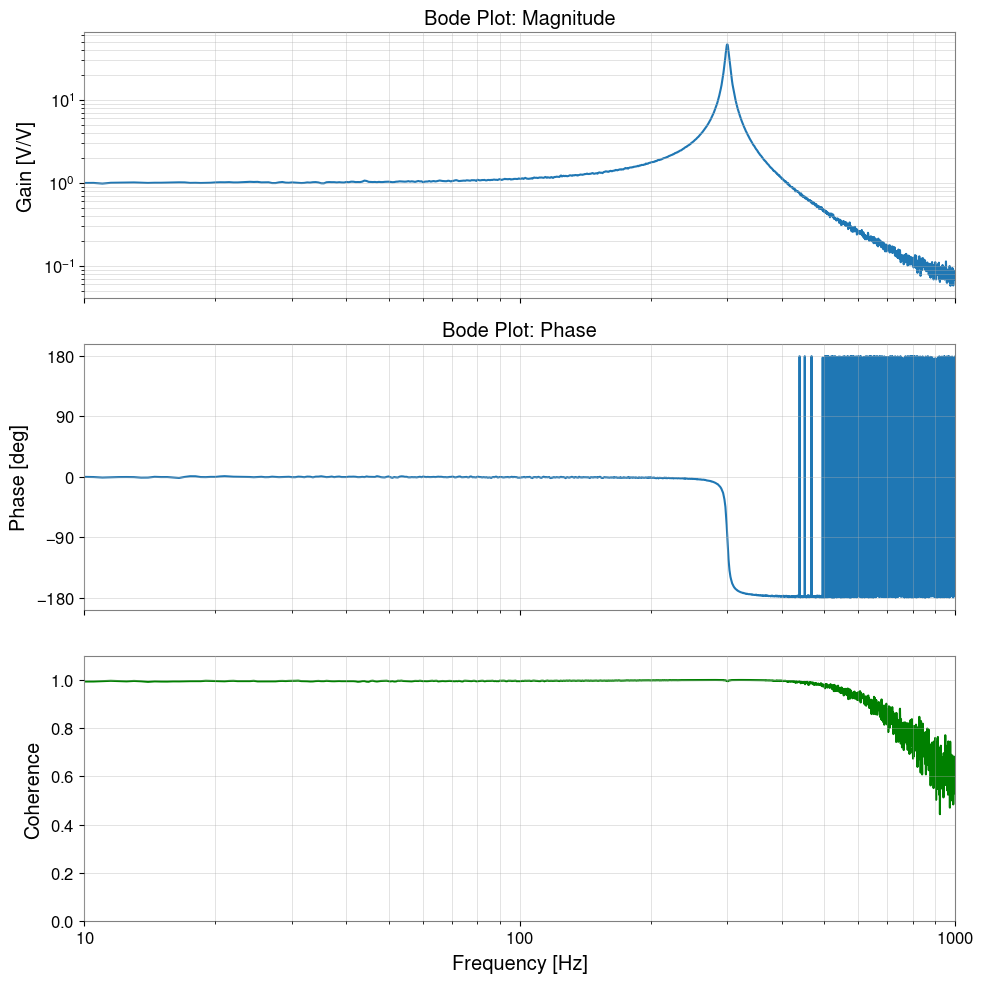

In [3]:
# FFT設定: 平均化のためにデータを区切る長さを指定
fftlength = 2.0  # 2秒ごとにFFTして平均化

# 伝達関数の計算 (Output / Input)
tf = ts_input.transfer_function(ts_output, fftlength=fftlength)

# コヒーレンスの計算
coh = ts_input.coherence(ts_output, fftlength=fftlength) ** 0.5

# --- プロット (ボード線図 & コヒーレンス) ---
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# 振幅 (Magnitude)
ax = axes[0]
ax.loglog(tf.abs(), label="Measured TF")
ax.set_ylabel("Gain [V/V]")
ax.set_title("Bode Plot: Magnitude")
ax.grid(True, which="both", alpha=0.5)

# 位相 (Phase)
ax = axes[1]
ax.plot(tf.degree(), label="Measured Phase")
ax.set_ylabel("Phase [deg]")
ax.set_title("Bode Plot: Phase")
ax.set_yticks(np.arange(-180, 181, 90))
ax.grid(True, which="both", alpha=0.5)

# コヒーレンス (Coherence)
ax = axes[2]
ax.plot(coh, color="green", label="Coherence")
ax.set_ylabel("Coherence")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylim(0, 1.1)
ax.set_xlim(10, 1000)
ax.grid(True, which="both", alpha=0.5)

plt.tight_layout()
plt.show()

## 3. モデルフィッティング

得られた伝達関数（特に共振付近）に対して、理論モデルをフィッティングします。
ここでは、単振動の伝達関数モデルを定義し、最小二乗法でパラメータ（$A, f_0, Q$）を求めます。

モデル式（ゲイン $A$ を含む）:
$$ H(f) = A \cdot \frac{f_0^2}{f_0^2 - f^2 + i (f f_0 / Q)} $$


In [4]:
# --- フィッティング用モデル関数の定義 ---
def resonator_model(f, amp, f0, Q):
    # f: 周波数配列
    # パラメータ: amp(ゲイン), f0(共振周波数), Q(Q値)

    # 計算式 (複素数)
    numerator = amp * (f0**2)
    denominator = (f0**2) - (f**2) + 1j * (f * f0 / Q)
    return numerator / denominator


# --- フィッティングの実行 ---
# データ全体を使うと広帯域すぎてフィットが難しい場合があるため、
# 共振付近 (100Hz ~ 500Hz) にデータを切り出します。
tf_crop = tf.crop(100, 500)

# 初期値の推定 (目視またはピーク探索で決める)
# ここでは f0=300付近に見えるため、それを初期値にします
p0 = {"amp": 1.0, "f0": 300.0, "Q": 10.0}

# フィッティング実行
# FrequencySeries の .fit() メソッドは複素数データのまま実部・虚部を同時にフィットします
result = tf_crop.fit(resonator_model, p0=p0)

print(result)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.474 (χ²/ndof = 0.0)      │              Nfcn = 116              │
│ EDM = 7.46e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

## 4. 結果の確認

フィッティング結果を数値で確認し、測定データに重ねてプロットします。
`FitResult.plot()` メソッドは、複素数データの場合、自動的にボード線図（振幅・位相）を描画します。


--- Estimated Parameters ---
Resonance Frequency (f0): 299.9944 Hz (True: 300.0)
Quality Factor (Q):       49.5975      (True: 50.0)
Gain (Amp):               0.9343


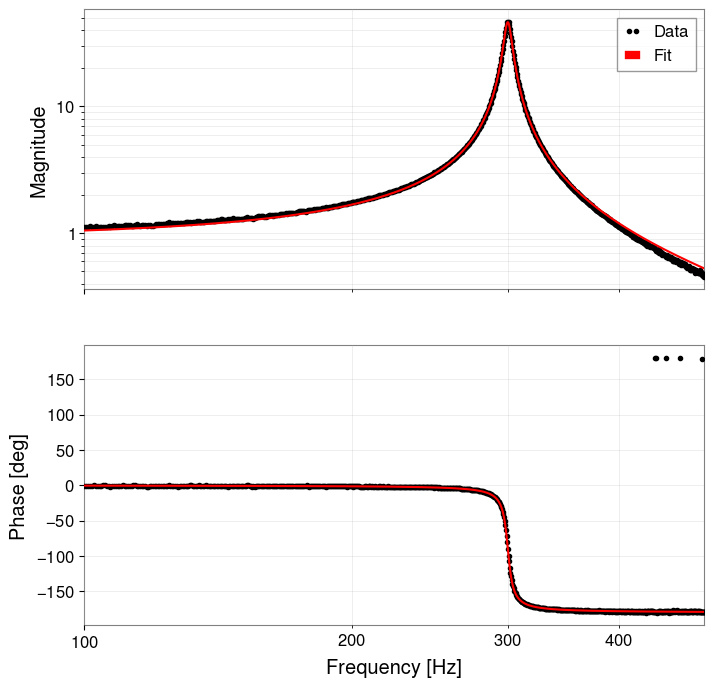

In [5]:
# --- 結果の表示 ---
print("--- Estimated Parameters ---")
print(f"Resonance Frequency (f0): {result.params['f0']:.4f} Hz (True: {f0_true})")
print(f"Quality Factor (Q):       {result.params['Q']:.4f}      (True: {Q_true})")
print(f"Gain (Amp):               {result.params['amp']:.4f}")

# --- プロット ---
# result.plot() は複素数の場合、振幅と位相の2つのAxesを返します
axes = result.plot()
plt.show()